# Imports

In [2]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne

# Model of Interest Must be Built For Evaluation (Include Associated Data Loader)
- This ust be done because the weights are saved, not the actual Keras models. So we must build the same model and load in the weights of interest

## 2D Weakly Supervised NCC US-MRI:

In [3]:
#model

from tensorflow.keras import layers
from tensorflow import keras

def get_model(moving_image_shape, fixed_image_shape, with_label_inputs=True, up_filters=[64, 128, 256], down_filters=[256, 128, 64, 32]):

    input_moving_image = keras.Input(moving_image_shape)
    input_fixed_image = keras.Input(fixed_image_shape)

    if with_label_inputs:
        input_moving_label = keras.Input(moving_image_shape)
        input_fixed_label = keras.Input(fixed_image_shape)

    concatenate_layer = layers.Concatenate(axis=-1)([input_moving_image, input_fixed_image])

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(concatenate_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in up_filters:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in down_filters:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    out_ddf = layers.Conv2D(2, 3, activation="linear", padding="same")(x)

    # Define the model
    if with_label_inputs:
        model = keras.Model(inputs=[input_moving_image, input_fixed_image, input_moving_label, input_fixed_label], outputs=[out_ddf])
    else:
        model = keras.Model(inputs=[input_moving_image, input_fixed_image], outputs=[out_ddf])
    return model

In [4]:
#data generator

from skimage.transform import resize

import nibabel as nib

def resize_2d_image(image, shape):
    image= image.squeeze()
    resized_image = resize(image, output_shape=shape)
    if np.amax(resized_image) == np.amin(resized_image):
        normalised_image = resized_image
    else:
        normalised_image = (resized_image - np.amin(resized_image)) / (np.amax(resized_image) - np.amin(resized_image))
    return normalised_image

def train_generator_(f_path, batch_size, moving_image_shape, fixed_image_shape, with_label_inputs=True):
    moving_images_path = os.path.join(f_path, 'us_images')
    fixed_images_path = os.path.join(f_path, 'mr_images')

    if with_label_inputs:
        moving_labels_path = os.path.join(f_path, 'us_labels')
        fixed_labels_path = os.path.join(f_path, 'mr_labels')

    all_names = np.array(os.listdir(fixed_images_path))

    while True:

        batch_names = all_names[np.random.permutation(len(all_names))[:batch_size]]

        moving_images_batch = np.zeros((batch_size, *moving_image_shape))
        fixed_images_batch = np.zeros((batch_size, *fixed_image_shape))

        if with_label_inputs:
            moving_labels_batch = np.zeros((batch_size, *moving_image_shape))
            fixed_labels_batch = np.zeros((batch_size, *fixed_image_shape))

        for i, f_name in enumerate(batch_names):
            moving_image = nib.load(os.path.join(moving_images_path, f_name)).get_fdata()
            fixed_image = nib.load(os.path.join(fixed_images_path, f_name)).get_fdata()
            # TAKE A SLICE FROM THE 3D IMAGE
            slice_index_moving = moving_image.shape[0] // 2
            slice_index_fixed = fixed_image.shape[0] // 2
            moving_image = moving_image[slice_index_moving,:,:]
            fixed_image = fixed_image[slice_index_fixed,:,:]

            if with_label_inputs:
                moving_label = nib.load(os.path.join(moving_labels_path, f_name)).get_fdata()
                fixed_label = nib.load(os.path.join(fixed_labels_path, f_name)).get_fdata()

                label_to_select = np.random.randint(6) #pick one label randomly for training

            moving_images_batch[i] = resize_2d_image(moving_image, moving_image_shape)
            fixed_images_batch[i] = resize_2d_image(fixed_image, fixed_image_shape)

            if with_label_inputs:
                slice_index_moving = moving_label.shape[0] // 2
                slice_index_fixed = fixed_label.shape[0] // 2
                moving_labels_batch[i] = resize_2d_image(moving_label[slice_index_moving, :, :, label_to_select], moving_image_shape)
                fixed_labels_batch[i] = resize_2d_image(fixed_label[slice_index_fixed, :, :, label_to_select], fixed_image_shape)

        zero_phis = np.zeros([batch_size, *moving_image_shape[:-1], 2])

        if with_label_inputs:
            inputs = (
                tf.convert_to_tensor(moving_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(moving_labels_batch, dtype=tf.float32),
                tf.convert_to_tensor(fixed_labels_batch, dtype=tf.float32)
            )
            outputs = (
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(zero_phis, dtype=tf.float32),
                tf.convert_to_tensor(fixed_labels_batch, dtype=tf.float32),
            )

        else:
            inputs = (
                tf.convert_to_tensor(moving_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32)
            )
            outputs = (
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(zero_phis, dtype=tf.float32)
            )

        yield inputs, outputs

def test_generator(f_path, batch_size, moving_image_shape, fixed_image_shape, start_index, end_index, label_num, with_label_inputs=True):
    moving_images_path = os.path.join(f_path, 'us_images')
    fixed_images_path = os.path.join(f_path, 'mr_images')

    if with_label_inputs:
        moving_labels_path = os.path.join(f_path, 'us_labels')
        fixed_labels_path = os.path.join(f_path, 'mr_labels')

    all_names = np.array(os.listdir(fixed_images_path))[start_index: end_index]

    if start_index and end_index is not None:
        n_steps = int(np.floor((end_index - start_index) / batch_size))
    else:
        start_index = 0
        end_index = len(all_names)
        n_steps =int( np.floor((end_index - start_index) / batch_size))

    for step in range(n_steps):

        batch_names = all_names[step*batch_size:(step*batch_size)+batch_size]

        moving_images_batch = np.zeros((batch_size, *moving_image_shape))
        fixed_images_batch = np.zeros((batch_size, *fixed_image_shape))

        if with_label_inputs:
            moving_labels_batch = np.zeros((batch_size, *moving_image_shape))
            fixed_labels_batch = np.zeros((batch_size, *fixed_image_shape))

        for i, f_name in enumerate(batch_names):
            moving_image = nib.load(os.path.join(moving_images_path, f_name)).get_fdata()
            fixed_image = nib.load(os.path.join(fixed_images_path, f_name)).get_fdata()
            # TAKE A SLICE FROM THE 3D IMAGE
            slice_index_moving = moving_image.shape[0] // 2
            slice_index_fixed = fixed_image.shape[0] // 2
            moving_image = moving_image[slice_index_moving,:,:]
            #print('*', moving_image.shape)
            fixed_image = fixed_image[slice_index_fixed,:,:]

            if with_label_inputs:
                moving_label = nib.load(os.path.join(moving_labels_path, f_name)).get_fdata() # if label not available, just pass zeros
                fixed_label = nib.load(os.path.join(fixed_labels_path, f_name)).get_fdata() # if label not available, just pass zeros

                label_to_select = label_num #pick one label randomly for training

            moving_images_batch[i] = resize_2d_image(moving_image, moving_image_shape)
            fixed_images_batch[i] = resize_2d_image(fixed_image, fixed_image_shape)

            if with_label_inputs:
                slice_index_moving = moving_label.shape[0] // 2
                slice_index_fixed = fixed_label.shape[0] // 2
                moving_labels_batch[i] = resize_2d_image(moving_label[slice_index_moving, :, :, label_to_select], moving_image_shape)
                fixed_labels_batch[i] = resize_2d_image(fixed_label[slice_index_fixed, :, :, label_to_select], fixed_image_shape)

        zero_phis = np.zeros([batch_size, *moving_image_shape[:-1], 2])

        if with_label_inputs:
            inputs = [moving_images_batch, fixed_images_batch, moving_labels_batch, fixed_labels_batch]
            outputs = [fixed_images_batch, zero_phis, fixed_labels_batch]
        else:
            inputs = [moving_images_batch, fixed_images_batch]
            outputs = [fixed_images_batch, zero_phis]

        yield (inputs, outputs)

# Metrics
- The following code is for the metrics used to evaluate the given model

In [5]:
def resize_3d_image_(image, shape):
    # Convert TensorFlow tensor to NumPy array if needed
    if hasattr(image, 'numpy'):
        image = image.numpy()
    elif isinstance(image, tf.Tensor):
        image = image.numpy()

    if hasattr(shape, 'numpy'):
        shape = shape.numpy()
    elif isinstance(shape, tf.Tensor):
        shape = shape.numpy()
    
    resized_image = resize(image, output_shape=shape)
    if np.amax(resized_image) == np.amin(resized_image):
        normalised_image = resized_image
    else:
        normalised_image = (resized_image - np.amin(resized_image)) / (np.amax(resized_image) - np.amin(resized_image))
    return normalised_image

In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tensorflow as tf
import numpy as np
from scipy.ndimage import _ni_support
from scipy.ndimage import generate_binary_structure, distance_transform_edt, binary_erosion

#from data_generator import resize_3d_image
from tqdm import tqdm

# import SimpleITK as sitk

# adapted from voxelmorph
def DSC(y_true, y_pred):
        
    # ndims = len(y_pred.get_shape().as_list()) - 2
    # vol_axes = list(range(1, ndims + 1))

    # top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    # bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    # div_no_nan = tf.math.divide_no_nan if hasattr(
    #     tf.math, 'divide_no_nan') else tf.div_no_nan  
    # dice = tf.reduce_mean(div_no_nan(top, bottom))
    dice = np.array(-1.0 * vxm.losses.Dice().loss(y_pred, y_true))
    print("dice: ", dice)
    return dice

def RDSC(y_true, y_pred):
        
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
        tf.math, 'divide_no_nan') else tf.div_no_nan  
    dice_scores_all = div_no_nan(top, bottom)
    sorted_indices = tf.argsort(dice_scores_all, axis=0, direction='DESCENDING')
    num_samples_dsc = tf.convert_to_tensor(tf.math.round(len(sorted_indices) * 0.68))
    dsc_scores_for_robustness = tf.gather(dice_scores_all, sorted_indices[:tf.cast(num_samples_dsc, dtype=tf.int32)])
    rdsc = tf.reduce_mean(tf.squeeze(dsc_scores_for_robustness))
    return rdsc

def compute_centroids(y_true, y_pred):    
    # find centroid locations in y_true
    y_true_centroids = []
    for i in range(len(y_true)):
        y_true_ones_indices = tf.where(y_true[i] > 0.5)
        image_centroid = tf.math.reduce_mean(y_true_ones_indices[:, :-1], axis=0)
        y_true_centroids.append(image_centroid)
    y_true_centroids = tf.stack(y_true_centroids)
    
    #find centroid locations in y_pred
    y_pred_centroids = []
    for i in range(len(y_pred)):
        y_pred_ones_indices = tf.where(y_pred[i] > 0.5)
        image_centroid = tf.math.reduce_mean(y_pred_ones_indices[:, :-1], axis=0)
        y_pred_centroids.append(image_centroid)
    y_pred_centroids = tf.stack(y_pred_centroids)
    return y_true_centroids, y_pred_centroids

def centroid_maes(y_true, y_pred):    
    y_true_centroids, y_pred_centroids = compute_centroids(y_true, y_pred)
    maes = tf.keras.losses.MAE(y_true_centroids, y_pred_centroids)
    return maes

def RMS(tensor):
    return tf.math.sqrt(tf.cast(tf.math.reduce_mean(tf.math.square(tensor)), dtype=tf.float32))

def TRE(all_label_maes):
    TREs = []
    for i in range(len(all_label_maes)):
        case = all_label_maes[i]
        case_rms = RMS(case)
        TREs.append(case_rms)
    mTRE = tf.math.reduce_mean(tf.stack(TREs))
    return mTRE

def RTRE(all_label_maes):
    TREs = []
    for i in range(len(all_label_maes)):
        case = all_label_maes[i]
        case_rms = RMS(case)
        TREs.append(case_rms)
    TREs =tf.stack(TREs)
    
    sorted_indices = tf.argsort(TREs, axis=0, direction='ASCENDING')
    num_samples_tre = tf.convert_to_tensor(tf.math.round(len(sorted_indices) * 0.68))
    # tres_for_robustness = TREs[0:tf.cast(num_samples_tre, dtype=tf.int32)]
    tres_for_robustness = tf.gather(TREs, sorted_indices[:tf.cast(num_samples_tre, dtype=tf.int32)])
    rtre = tf.reduce_mean(tf.squeeze(tres_for_robustness))
    return rtre

def RTs(all_label_maes):
    TREs = []
    for i in range(len(all_label_maes)):
        case = all_label_maes[i]
        
        sorted_indices = tf.argsort(case, axis=0, direction='ASCENDING')
        num_samples_case_rts = tf.convert_to_tensor(tf.math.round(len(sorted_indices) * 0.68))
        # case_for_rts = case[0:tf.cast(num_samples_case_rts, dtype=tf.int32)]
        case_for_rts = tf.gather(case, sorted_indices[:tf.cast(num_samples_case_rts, dtype=tf.int32)])
        
        case_rms = RMS(case_for_rts)
        TREs.append(case_rms)
    mTRE = tf.math.reduce_mean(tf.stack(TREs))
    return mTRE

# adapted from loli/medpy
def surface_distances(result, reference, voxelspacing=None, connectivity=1):
    
    result = resize_3d_image_(result, np.shape(reference))
    
    result = np.atleast_1d(np.array(result).astype(bool))
    reference = np.atleast_1d(np.array(reference).astype(bool))
    
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

# adapted from loli/medpy

    
def HD95(y_true, y_pred):
    
    all_hd95s = []
    print('computing hd')
    for i in tqdm(range(len(y_true))):
        
        if np.shape(y_true[i]) != np.shape(y_pred[i]):
            y_pred_to_use = resize_3d_image_(y_pred[i:i+1], np.shape(y_true[i:i+1]))
        else:
            y_pred_to_use = y_pred[i:i+1]
        
        # print(np.shape(y_pred_to_use), np.shape(y_true[i:i+1]))
        
        voxelspacing = None
        connectivity = 1
        hd1 = surface_distances(y_pred_to_use, y_true[i:i+1], voxelspacing, connectivity)
        hd2 = surface_distances(y_true[i:i+1], y_pred_to_use, voxelspacing, connectivity)
        try:
            hd95 = np.percentile(np.hstack((hd1, hd2)), 95)
        except IndexError:
            hd95 = 0.0
        all_hd95s.append(hd95)
    return np.mean(all_hd95s)

# def StDJD(ddf):
#     ddf_sitk = sitk.GetImageFromArray(ddf)
#     ddf_sitk.SetOrigin((0, 0, 0))
#     jacobian_determinant = sitk.DisplacementFieldJacobianDeterminant(ddf_sitk)
#     std_jacobian_determinant = np.std(sitk.GetArrayFromImage(jacobian_determinant))
#     return std_jacobian_determinant
def StDJD(ddf):
    """
    Compute std of Jacobian determinant for a 2D displacement field.
    ddf: numpy array of shape (H, W, 2)
    """
    # SimpleITK expects (W, H, components) ordering
    ddf_sitk = sitk.GetImageFromArray(ddf, isVector=True)
    ddf_sitk.SetOrigin((0, 0))
    
    jacobian_determinant = sitk.DisplacementFieldJacobianDeterminant(ddf_sitk)
    std_jacobian_determinant = np.std(sitk.GetArrayFromImage(jacobian_determinant))
    return std_jacobian_determinant

# Test Metrics

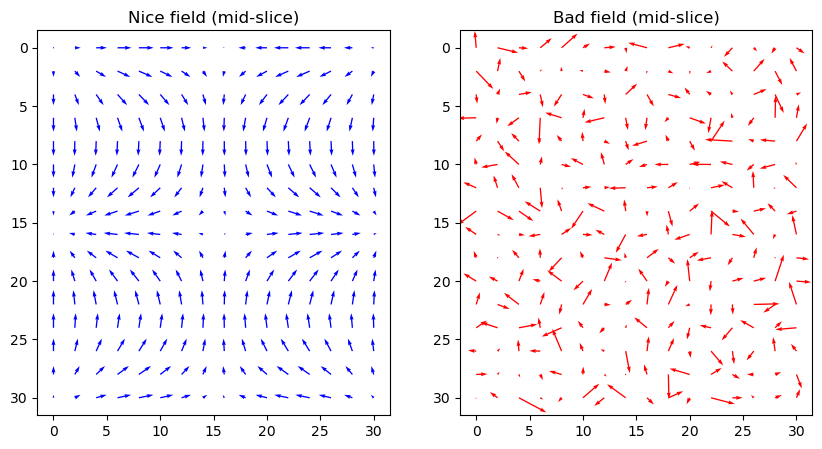

(32, 32, 32, 3)


In [26]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

def generate_ddf(shape=(32, 32, 32), visualize=True):
    """Generate a 'nice' and a 'bad' displacement field, optionally visualize."""
    Z, Y, X = shape
    grid_z, grid_y, grid_x = np.meshgrid(
        np.linspace(-1, 1, Z),
        np.linspace(-1, 1, Y),
        np.linspace(-1, 1, X),
        indexing="ij"
    )

    # "Nice" field: smooth sinusoidal deformations
    nice_ddf = np.zeros((Z, Y, X, 3), dtype=np.float32)
    nice_ddf[..., 0] = 0.2 * np.sin(np.pi * grid_x) * np.cos(np.pi * grid_y)
    nice_ddf[..., 1] = 0.2 * np.sin(np.pi * grid_y) * np.cos(np.pi * grid_z)
    nice_ddf[..., 2] = 0.2 * np.sin(np.pi * grid_z) * np.cos(np.pi * grid_x)

    # "Bad" field: random noise with large amplitude
    bad_ddf = np.random.randn(Z, Y, X, 3).astype(np.float32) * 2.0

    if visualize:
        mid_z = Z // 2
        step = 2  # downsample for clarity in quiver

        Y_coords, X_coords = np.mgrid[0:Y:step, 0:X:step]

        # Nice field slice
        U_nice = nice_ddf[mid_z, ::step, ::step, 0]
        V_nice = nice_ddf[mid_z, ::step, ::step, 1]

        # Bad field slice
        U_bad = bad_ddf[mid_z, ::step, ::step, 0]
        V_bad = bad_ddf[mid_z, ::step, ::step, 1]

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].quiver(X_coords, Y_coords, U_nice, V_nice, color="blue")
        axs[0].set_title("Nice field (mid-slice)")
        axs[0].invert_yaxis()

        axs[1].quiver(X_coords, Y_coords, U_bad, V_bad, color="red")
        axs[1].set_title("Bad field (mid-slice)")
        axs[1].invert_yaxis()

        plt.show()

    return nice_ddf, bad_ddf

# Example usage
nice_ddf, bad_ddf = generate_ddf()

In [8]:
a = StDJD(nice_ddf)
print(a)
b = StDJD(bad_ddf)
print(b)

0.034934614
8.745377


Image saved as fixed.nii.gz


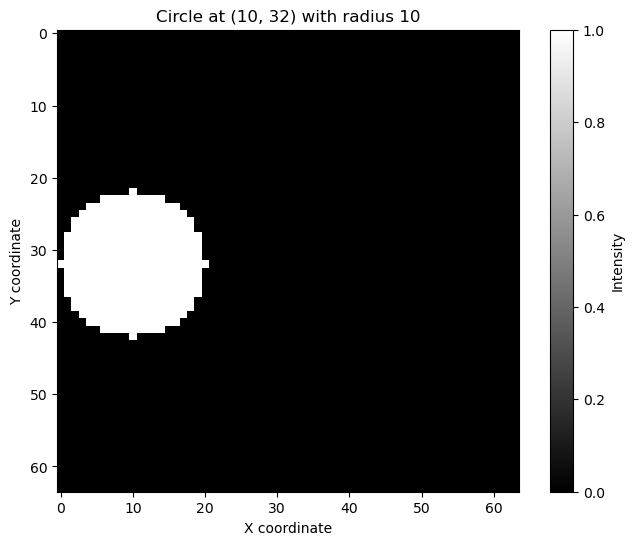

Image shape: (64, 64, 1)
Circle center: (10, 32)
Circle radius: 10 pixels
Image saved as moved.nii.gz


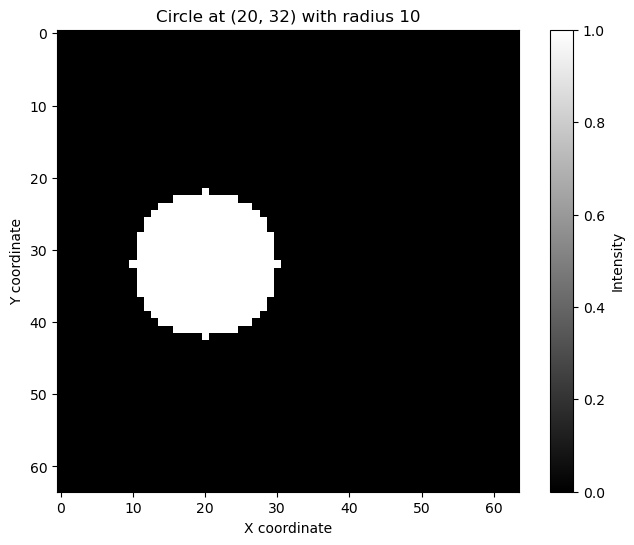

Image shape: (64, 64, 1)
Circle center: (20, 32)
Circle radius: 10 pixels
Fixed sum: 317.0
Moved sum: 317.0
Intersection: 127.0
Dice: 0.40063091482649843


2025-09-12 08:21:21.169649: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


TRE:  tf.Tensor(3.28125, shape=(), dtype=float32)
computing hd


100%|██████████| 64/64 [00:00<00:00, 1137.29it/s]

hd95:  3.096875


In [9]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def create_circle_image(center_x, center_y, radius, image_size=64):
    """
    Create a 64x64 image with a white circle on black background
    
    Parameters:
    center_x, center_y: coordinates of circle center (0-63)
    radius: radius of the circle in pixels
    image_size: size of the image (default: 64)
    
    Returns:
    NIfTI image object
    """
    # Create empty 3D array (64x64x1 for 2D slice)
    image_data = np.zeros((image_size, image_size, 1), dtype=np.float32)
    
    # Create meshgrid for coordinates
    y, x = np.ogrid[:image_size, :image_size]
    
    # Calculate distance from each point to the center
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Create circle mask
    circle_mask = distance <= radius
    
    # Set circle pixels to white (value 1.0)
    image_data[circle_mask, 0] = 1.0
    
    return image_data

def save_as_nii_gz(image_data, filename):
    """Save image data as NIfTI.gz file"""
    # Create NIfTI image with appropriate affine matrix
    affine = np.eye(4)
    nifti_img = nib.Nifti1Image(image_data, affine)
    
    # Save as compressed NIfTI
    nib.save(nifti_img, filename)
    print(f"Image saved as {filename}")

def visualize_image(image_data, title="Circle Image"):
    """Visualize the image using matplotlib"""
    # Extract 2D slice from 3D array
    slice_2d = image_data[:, :, 0]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(slice_2d, cmap='gray', vmin=0, vmax=1)
    plt.colorbar(label='Intensity')
    plt.title(title)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(False)
    plt.show()


# Parameters for the circle
CENTER_X = 10  # Center of the image (0-63)
CENTER_Y = 32  # Center of the image (0-63)
RADIUS = 10    # Radius of the circle

# Create the image
image_data = create_circle_image(CENTER_X, CENTER_Y, RADIUS)

# Save as NIfTI.gz
save_as_nii_gz(image_data, "fixed.nii.gz")

# Visualize the image
visualize_image(image_data, f"Circle at ({CENTER_X}, {CENTER_Y}) with radius {RADIUS}")

# Print image information
print(f"Image shape: {image_data.shape}")
print(f"Circle center: ({CENTER_X}, {CENTER_Y})")
print(f"Circle radius: {RADIUS} pixels")

# Parameters for the circle
CENTER_X = 20  # Center of the image (0-63)
CENTER_Y = 32  # Center of the image (0-63)
RADIUS = 10    # Radius of the circle

# Create the image
image_data = create_circle_image(CENTER_X, CENTER_Y, RADIUS)

# Save as NIfTI.gz
save_as_nii_gz(image_data, "moved.nii.gz")

# Visualize the image
visualize_image(image_data, f"Circle at ({CENTER_X}, {CENTER_Y}) with radius {RADIUS}")

# Print image information
print(f"Image shape: {image_data.shape}")
print(f"Circle center: ({CENTER_X}, {CENTER_Y})")
print(f"Circle radius: {RADIUS} pixels")

fixed = tf.convert_to_tensor(nib.load('fixed.nii.gz').get_fdata(), dtype='float32')
moved = tf.convert_to_tensor(nib.load('moved.nii.gz').get_fdata(), dtype='float32')

fixed_np = nib.load('fixed.nii.gz').get_fdata()
moved_np = nib.load('moved.nii.gz').get_fdata()


#dice = DSC(fixed, moved)

print("Fixed sum:", np.sum(fixed_np))
print("Moved sum:", np.sum(moved_np))
print("Intersection:", np.sum(fixed_np * moved_np))

from sklearn.metrics import jaccard_score

dice = 2*np.sum(fixed_np*moved_np)/(np.sum(fixed_np)+np.sum(moved_np))
print("Dice:", dice)

all_lim_maes = []
mae = centroid_maes(fixed, moved)
lim_mae = centroid_maes(fixed, moved)
all_lim_maes.append(lim_mae)
#print("mae: ", mae[mae !=0])
maes = [mae]
maes = [np.expand_dims(elem, -1) for elem in maes]
#print("maes: ", np.sum(maes))
all_maes_array = np.concatenate(maes, axis=-1)
maes = [np.expand_dims(elem, -1) for elem in maes]
all_maes_array = np.concatenate(maes, axis=-1)
idx = np.argwhere(np.all(all_maes_array[..., :] == 0, axis=0))
all_maes_array = np.delete(all_maes_array, idx, axis=1)

lim_maes = [np.expand_dims(elem, -1) for elem in all_lim_maes]
all_lim_maes_array = np.concatenate(lim_maes, axis=-1)
idx = np.argwhere(np.all(all_lim_maes_array[..., :] == 0, axis=0))
all_lim_maes_array = np.delete(all_lim_maes_array, idx, axis=1)
#print("all maes array: ", all_maes_array[all_maes_array != 0])
tre = TRE(all_maes_array)

print("TRE: ", tre)

hd95 = HD95(fixed, moved)
print("hd95: ", hd95)

# Evaluate Model Using the Metrics

In [11]:
def evaluation_graphs(model_save_path):
    # Load arrays
    val_dice = np.load(os.path.join(model_save_path, "val_dice.npy")).tolist()
    transformer_losses = np.load(os.path.join(model_save_path, "transformer_losses.npy")).tolist()
    losses = np.load(os.path.join(model_save_path, "losses.npy")).tolist()
    conv3d_losses = np.load(os.path.join(model_save_path, "conv2d_losses.npy")).tolist()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.subplots_adjust(wspace=0.5) 
    
    plt.plot(losses, label="Loss")
    plt.plot(transformer_losses, label="Transformer Loss")
    plt.xlabel('Trials')
    plt.ylabel('Losses')
    plt.legend()  

    plt.subplot(1, 3, 2)
    plt.plot(conv3d_losses, label="Conv3D Loss")
    plt.xlabel('Trials')
    plt.ylabel('Losses')
    plt.legend()  
                         
    plt.subplot(1, 3, 3)
    plt.plot(val_dice, 'r')
    plt.xlabel('Trials')
    plt.ylabel('Dice')
    plt.savefig(r'voxelmorph_val_dice_1.png')
    plt.show()


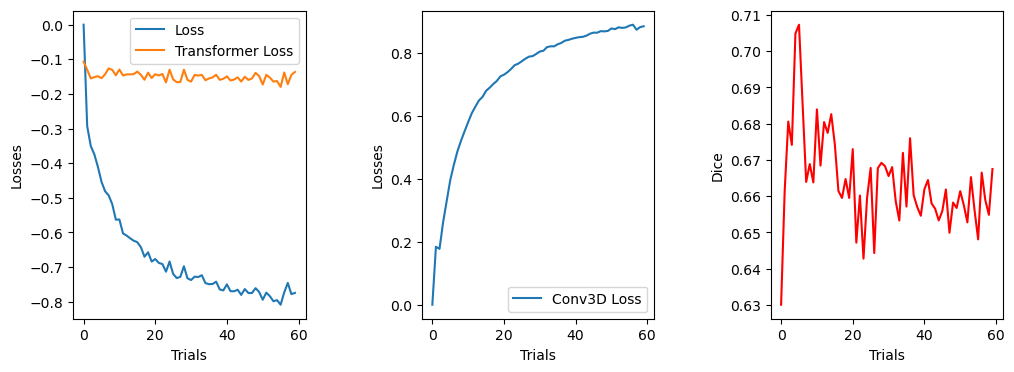

In [13]:
evaluation_graphs('2D_WS_US-MRI_NCC_checkpoints')

In [29]:
import os, re
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import SimpleITK as sitk

def evaluate_model(last_trial, latest_weights, model_save_path):

    evaluation_graphs(model_save_path)
    # ------------------------------
    # Setup
    # ------------------------------
    moving_image_shape = (80, 80, 1)
    fixed_image_shape  = (80, 80, 1)
    
    f_path   = "nifti_data/train"
    val_path = "nifti_data/val"
    
    batch_size = 32   # reduce if you are running out of RAM
    
    # ------------------------------
    # Build model (always rebuild arch)
    # ------------------------------
    
    model = get_model(moving_image_shape, fixed_image_shape, with_label_inputs=False)
    spatial_transformer = vxm.layers.SpatialTransformer(name="transformer")
    
    moving_image = model.input[0]
    fixed_image  = model.inputs[1]
    input_moving_label = keras.Input(moving_image_shape, name="moving_label")
    input_fixed_label  = keras.Input(fixed_image_shape,  name="fixed_label")
    inputs=[moving_image, fixed_image, input_moving_label, input_fixed_label]
    
    ddf = model.outputs[0]
    moved_image = spatial_transformer([moving_image, ddf])
    moved_label = spatial_transformer([input_moving_label, ddf])
    # dummy op just to keep fixed_label in graph
    fixed_label = input_fixed_label * 1.0  
    
    outputs = [moved_image, ddf, moved_label]
    registration_model = keras.Model(inputs=inputs, outputs=outputs)

    lambda_param = 0.05
    
    registration_model.compile(
        optimizer="Adam",
        loss=[vxm.losses.NCC().loss, vxm.losses.Grad("l2").loss, vxm.losses.Dice().loss],
        loss_weights=[1, lambda_param, 1]
    )
    
    # ------------------------------
    # Resume from last checkpoint
    # ------------------------------
    if latest_weights is not None:
        print(f"Resuming from {latest_weights} (trial {last_trial})")
        registration_model.load_weights(latest_weights)
        start_trial = last_trial
    else:
        print("No previous weights found, starting fresh")
        start_trial = 0
    
    print("===================================================")
    print("RESULTS FOR VALIDATION SET")
    print("===================================================")
    
    for trial in [0]:
        print(f'Evaluation for Trial {start_trial}:')
    
        all_dscs = []
        all_rdscs = []
        maes = []
        all_hd95s = []
        
        all_lim_hd95s = []
        all_lim_maes = []

        all_ddfs = []
        
        for label_num in [0]: # Only interest in gland for 2D case
            val_gen = test_generator(val_path, 8, moving_image_shape, fixed_image_shape, start_index=None, end_index=None, label_num=label_num, with_label_inputs=True)
            count = 0
            while True:
                try:
                    (val_inputs, val_outputs) = next(val_gen)
                    moving_images_val, fixed_images_val, moving_labels_val, fixed_labels_val = val_inputs
                    fixed_images_val, zero_phis_val, fixed_labels_val = val_outputs
                    _, ddf_val, _ = registration_model.predict((moving_images_val, fixed_images_val, moving_labels_val, fixed_labels_val), verbose=0)
    
                    all_ddfs.append(ddf_val)
                    
                    moved_labels_val = spatial_transformer([moving_labels_val, ddf_val])
                    moved_images_val = spatial_transformer([moving_images_val, ddf_val])
    
                    if count == 0:
                        # VISUALLY CHECK FIXED, MOVING MOVED IMAGES
                        print(moving_images_val.shape)
                        plt.subplot(1,3,1)
                        plt.imshow(tf.squeeze(moved_images_val[0]), cmap='gray')
                        plt.title('Moved Image')
        
                        plt.subplot(1,3,2)
                        plt.imshow(tf.squeeze(moving_images_val[0]), cmap='gray')
                        plt.title('Moving Image')
        
                        plt.subplot(1,3,3)
                        plt.imshow(tf.squeeze(fixed_images_val[0]), cmap='gray')
                        plt.title('Fixed Image')
                        plt.show()
    
                        # VISUALLY CHECK LABELS
                        plt.subplot(1,3,1)
                        plt.imshow(tf.squeeze(moved_labels_val[0]), cmap='gray')
                        plt.title('Moved Label')
                        plt.subplot(1,3,2)
                        plt.imshow(tf.squeeze(moving_labels_val[0]), cmap='gray')
                        plt.title('Moving Label')
                        plt.subplot(1,3,3)
                        plt.imshow(tf.squeeze(fixed_labels_val[0]), cmap='gray')
                        plt.title('Fixed Label')
                        plt.show()
    
                        val_pred = tuple(ddf_val)
                        flow = val_pred[1].squeeze()[::3,::3]
                        print("ddf_val shape: ", ddf_val.shape)
                        
                        ddf_flow = np.stack([-ddf_val[0][..., 1], -ddf_val[0][..., 0]], axis=-1)
                        ne.plot.flow([ddf_flow], width=5);
                        count += 1

                    arg_moved = tf.convert_to_tensor(moved_labels_val, dtype='float32')
                    arg_fixed = tf.convert_to_tensor(fixed_labels_val, dtype='float32')

                    dice_score = np.array(-1.0 * vxm.losses.Dice().loss(arg_fixed, arg_moved))
                    all_dscs.append(dice_score)
                    rdsc = RDSC(arg_moved, arg_fixed)
                    all_rdscs.append(rdsc)
                    
                    mae = centroid_maes(arg_fixed, arg_moved)
                    hd95 = HD95(arg_fixed, arg_moved)
                    
                    lim_hd95 = HD95(arg_fixed, arg_moved)
                    lim_mae = centroid_maes(arg_fixed, arg_moved)
                                
                    maes.append(mae)
                    all_hd95s.append(hd95)
                    all_lim_hd95s.append(lim_hd95)
                    all_lim_maes.append(lim_mae)
    
                except (IndexError, StopIteration) as e:
                    break
    
        fin_DSC = np.mean(all_dscs)
        print(all_dscs)
        fin_RDSC = np.mean(all_rdscs)
        fin_HD95 = np.mean(all_hd95s)
        fin_lim_HD95 = np.mean(all_lim_hd95s)
    
        maes = [np.expand_dims(elem, -1) for elem in maes]
        all_maes_array = np.concatenate(maes, axis=-1)
        idx = np.argwhere(np.all(all_maes_array[..., :] == 0, axis=0))
        all_maes_array = np.delete(all_maes_array, idx, axis=1)
        
        lim_maes = [np.expand_dims(elem, -1) for elem in all_lim_maes]
        all_lim_maes_array = np.concatenate(lim_maes, axis=-1)
        idx = np.argwhere(np.all(all_lim_maes_array[..., :] == 0, axis=0))
        all_lim_maes_array = np.delete(all_lim_maes_array, idx, axis=1)
        
        fin_TRE = TRE(all_maes_array)
        fin_RTRE = RTRE(all_maes_array)
        fin_RTs = RTs(all_maes_array)
        
        fin_lim_TRE = TRE(all_lim_maes_array)
        fin_lim_RTRE = RTRE(all_lim_maes_array)
        fin_lim_RTs = RTs(all_lim_maes_array)

        stdjds = []
        for ddf in all_ddfs:
            print("Type: ", type(ddf[0]))
            stdjd = StDJD(ddf[0])
            stdjds.append(stdjd)
        
        fin_StDJD = np.mean(stdjds)
        
        print(f'\nALL METRICS:\n\n'
          f'DSC: {fin_DSC}\n',
          f'RDSC: {fin_RDSC}\n',
          f'HD95: {fin_HD95}\n',
          f'TRE: {fin_TRE}\n',
          f'RTRE: {fin_RTRE}\n',
          f'RTs: {fin_RTs}\n',
          f'StDJD: {fin_StDJD}\n',
          )

        print("===================================================")
        print("RESULTS FOR TRAINING SET")
        print("===================================================")

        val_dice = []
        losses = []
        transformer_losses = []
        conv3d_losses = []
        
        for trial in [0]:
            print(f'Evaluation for Trial {start_trial}:')
        
            all_dscs = []
            all_rdscs = []
            maes = []
            all_hd95s = []
            
            all_lim_hd95s = []
            all_lim_maes = []
    
            all_ddfs = []
            
            for label_num in [0]:
                val_gen = test_generator(f_path, 32, moving_image_shape, fixed_image_shape, start_index=None, end_index=None, label_num=label_num, with_label_inputs=True)
                count = 0
                while True:
                    try:
                        (val_inputs, val_outputs) = next(val_gen)
                        moving_images_val, fixed_images_val, moving_labels_val, fixed_labels_val = val_inputs
                        fixed_images_val, zero_phis_val, fixed_labels_val = val_outputs
                        _, ddf_val, _ = registration_model.predict((moving_images_val, fixed_images_val, moving_labels_val, fixed_labels_val), verbose=0)
        
                        all_ddfs.append(ddf_val)
                        
                        moved_labels_val = spatial_transformer([moving_labels_val, ddf_val])
                        moved_images_val = spatial_transformer([moving_images_val, ddf_val])
    
                        arg_moved = tf.convert_to_tensor(moved_labels_val, dtype='float32')
                        arg_fixed = tf.convert_to_tensor(fixed_labels_val, dtype='float32')
    
                        dice_score = np.array(-1.0 * vxm.losses.Dice().loss(arg_fixed, arg_moved))
                        all_dscs.append(dice_score)
                        rdsc = RDSC(arg_moved, arg_fixed)
                        all_rdscs.append(rdsc)
                        
                        mae = centroid_maes(arg_fixed, arg_moved)
                        hd95 = HD95(arg_fixed, arg_moved)
                        
                        lim_hd95 = HD95(arg_fixed, arg_moved)
                        lim_mae = centroid_maes(arg_fixed, arg_moved)
                                    
                        maes.append(mae)
                        all_hd95s.append(hd95)
                        all_lim_hd95s.append(lim_hd95)
                        all_lim_maes.append(lim_mae)
        
                    except (IndexError, StopIteration) as e:
                        break
        
            fin_DSC = np.mean(all_dscs)
            print(all_dscs)
            fin_RDSC = np.mean(all_rdscs)
            fin_HD95 = np.mean(all_hd95s)
            fin_lim_HD95 = np.mean(all_lim_hd95s)
        
            maes = [np.expand_dims(elem, -1) for elem in maes]
            all_maes_array = np.concatenate(maes, axis=-1)
            idx = np.argwhere(np.all(all_maes_array[..., :] == 0, axis=0))
            all_maes_array = np.delete(all_maes_array, idx, axis=1)
            
            lim_maes = [np.expand_dims(elem, -1) for elem in all_lim_maes]
            all_lim_maes_array = np.concatenate(lim_maes, axis=-1)
            idx = np.argwhere(np.all(all_lim_maes_array[..., :] == 0, axis=0))
            all_lim_maes_array = np.delete(all_lim_maes_array, idx, axis=1)
            
            fin_TRE = TRE(all_maes_array)
            fin_RTRE = RTRE(all_maes_array)
            fin_RTs = RTs(all_maes_array)
            
            fin_lim_TRE = TRE(all_lim_maes_array)
            fin_lim_RTRE = RTRE(all_lim_maes_array)
            fin_lim_RTs = RTs(all_lim_maes_array)
    
            stdjds = []
            for ddf in all_ddfs:
                stdjd = StDJD(ddf[0])
                stdjds.append(stdjd)
            
            fin_StDJD = np.mean(stdjds)
            
            print(f'\nALL METRICS:\n\n'
              f'DSC: {fin_DSC}\n',
              f'RDSC: {fin_RDSC}\n',
              f'HD95: {fin_HD95}\n',
              f'TRE: {fin_TRE}\n',
              f'RTRE: {fin_RTRE}\n',
              f'RTs: {fin_RTs}\n',
              f'StDJD: {fin_StDJD}\n',
              )

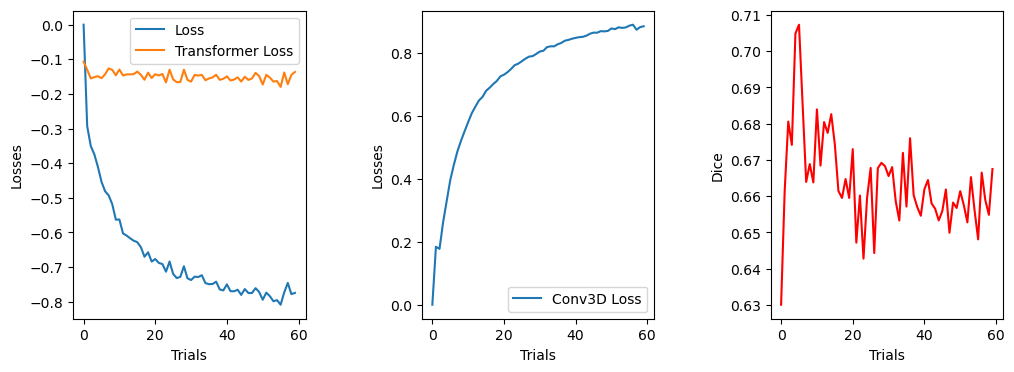

Resuming from 2D_WS_US-MRI_NCC_checkpoints/weights_trial_8.weights.h5 (trial 8)
RESULTS FOR VALIDATION SET
Evaluation for Trial 8:


E0000 00:00:1757660201.067800 1575500 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'functional_15_1/up_sampling2d_59_1/Repeat/ExpandDims' exist for missing node 'functional_15_1/add_52_1/Add'.


(8, 80, 80, 1)


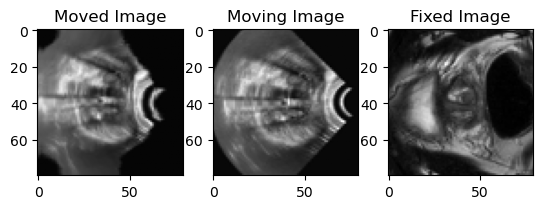

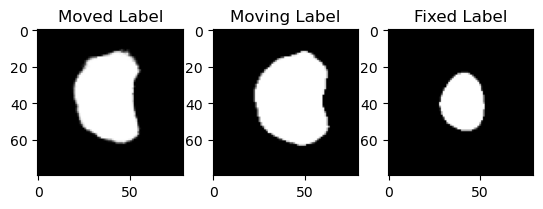

ddf_val shape:  (8, 80, 80, 2)


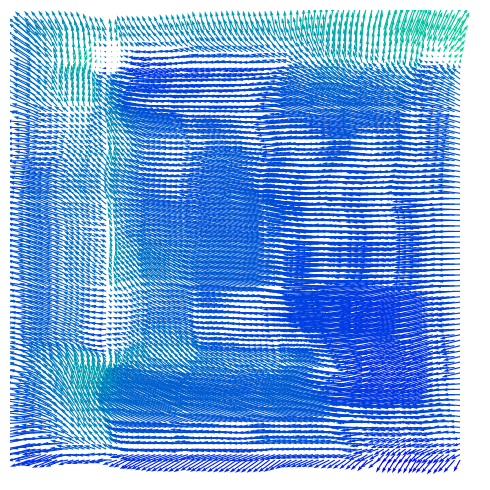

computing hd


100%|██████████| 8/8 [00:00<00:00, 249.96it/s]


computing hd


100%|██████████| 8/8 [00:00<00:00, 252.02it/s]

[array(0.66886604, dtype=float32)]
Type:  <class 'numpy.ndarray'>

ALL METRICS:

DSC: 0.6688660383224487
 RDSC: 0.7495254278182983
 HD95: 8.900209715966604
 TRE: 3.125
 RTRE: 1.7000000476837158
 RTs: 3.125
 StDJD: 0.3708566725254059

RESULTS FOR TRAINING SET
Evaluation for Trial 8:


computing hd


100%|██████████| 32/32 [00:00<00:00, 250.88it/s]


computing hd


100%|██████████| 32/32 [00:00<00:00, 251.51it/s]


computing hd


100%|██████████| 32/32 [00:00<00:00, 249.13it/s]


computing hd


100%|██████████| 32/32 [00:00<00:00, 251.66it/s]


[array(0.74638474, dtype=float32), array(0.68949825, dtype=float32)]

ALL METRICS:

DSC: 0.7179415225982666
 RDSC: 0.7732211351394653
 HD95: 7.824272775106941
 TRE: 4.295149803161621
 RTRE: 3.3257062435150146
 RTs: 2.9375
 StDJD: 0.35806506872177124



In [31]:
evaluate_model(8, '2D_WS_US-MRI_NCC_checkpoints/weights_trial_8.weights.h5', '2D_WS_US-MRI_NCC_checkpoints')